# Evaluations

In [ ]:
import pandas as pd
import os
from qdrant_client import QdrantClient, models
from fastembed import TextEmbedding
from google import genai
from google.genai import types
import ollama
from tqdm.auto import tqdm
from pprint import pprint
from dotenv import load_dotenv
import re

load_dotenv()

api_key = os.getenv("GEMINI_API_KEY")

client_genai = genai.Client(api_key=api_key)

model_name = 'BAAI/bge-small-en'
embed_model = TextEmbedding(model_name=model_name, provider="torch", device="cuda")
client_qdrant = QdrantClient("http://localhost:6333", timeout=60.0)

DATA_PATH = "../data/"
#docker run -p 6333:6333 -p 6334:6334 -v ~/qdrant_storage:/qdrant/storage qdrant/qdrant

# Retrieval evaluation

## Ground truth dataset generation

In [ ]:
ground_truth = []

prompt_sys = """You are a helpful assistant that generates exactly {N} blocks of questions from a set of research articles.
Follow these strict rules:

1. Output exactly {N} articles, no more, no less.
2. Each block must be formatted like this:

**Article i:**
Q1: [question here]
Q2: [question here]

3. Articles must be numbered starting from 0 up to {N_1} with no gaps and no duplicates.
4. Each article has exactly 2 questions.
5. Do not repeat or merge articles. If an article is missing information, still output its block with placeholder questions.
6. Do not add explanations, comments, or extra text outside the blocks.
"""


prompt_template = """You are given metadata for {N} scientific articles.

### Task
For each article, generate exactly 2 simple, natural questions in English that a researcher might ask.
The questions must be directly inspired by the article title and authors.

### Rules
1. Base the questions only on the title and authors (no assumptions).
2. Number the outputs by article index, maintaining sequential order.
3. Each question must be at most 12 words.


### Input
List of articles:
{articles}
"""

batch_size = 10
pattern_question = r"(?:Q[12]:|Question [12]:)\s*(.*)"
pattern_art = r"(?:\*\*Article\s+\d+(?:\s+Questions:|:[^*]*|\s*\([^)]*\):)\*\*|Article\s+\d+:)"

try:
    gt_df = pd.read_csv(DATA_PATH+"ground_truth.csv")
    
except Exception as e:
    df = pd.read_parquet(DATA_PATH+"articles_w_embeds.parquet").sample(5000, random_state=42)

    for i in tqdm(range(0, len(df), batch_size), desc="Processing"):
        batch = df.iloc[i:i+batch_size]
        #print(batch.title)
        articles = "\n\n".join(
            f"Article {j}\nTitle: {row['title']}\nAuthors: {row['authors']}"
            for j, (_, row) in enumerate(batch.iterrows())
        )

        response = ollama.chat(
            model= "phi3:instruct", #"phi3:mini",  #"phi3:mini-4k"
            messages=[
                {"role": "system", "content": prompt_sys.format(N=len(batch), N_1=len(batch)-1)},
                {"role": "user", "content": prompt_template.format(N=len(batch), articles=articles)}],
            options={
                "temperature": 0
            }
        )

        content = response['message']['content']
        article_blocks = re.split(pattern_art, content)[1:]
        if len(article_blocks) == batch_size:
            for j, (_, row) in enumerate(batch.iterrows()):
                    questions = re.findall(pattern_question, article_blocks[j], flags=re.IGNORECASE)
                    for q in questions:
                        #print(q)
                        q = q.strip()
                        if len(q.split()) >= 4:
                            if q[-1] != '?':
                                q = q + '?'
                            ground_truth.append({
                                "question": q,
                                "relevant_document_ids": row['id'],
                                "categories": row['categories'],
                                "authors": row['authors'],
                                "year": row['year']
                            })

    gt_df = pd.DataFrame(ground_truth)
    gt_df.to_csv(DATA_PATH+"ground_truth.csv", index=False, mode='a')

#ollama run phi3:mini

Processing:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
#gt_df = pd.read_csv(DATA_PATH+"ground_truth.csv")
ground_truth = gt_df[["question", "relevant_document_ids", "categories", "authors", "year"]].to_dict("records")
len(ground_truth)

9880

## Information retrieval metrics

In [4]:
def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

#Mean Reciprocal Rank
def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

## Search evaluation pipeline

In [ ]:
def search_papers(query, collection_name="articles-rag-cos", categories=None, top_k=5):
    must_filters = []
    if categories:
        for cat in categories:
            must_filters.append(
                models.FieldCondition(
                    key="categories",
                    match=models.MatchText(text=cat)
                )
            )

    results = client_qdrant.query_points(
        collection_name=collection_name,
        query=models.Document(
            text=query,
            model=model_name
        ),
        limit=top_k,
        query_filter=models.Filter(
            must=must_filters if categories else None
        ),
    )
    return results

def evaluate(ground_truth, search_function):
    relevance_total = []
    for q in tqdm(ground_truth):
        doc_id = q['relevant_document_ids']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

def qdrant_search(query, collection_name="articles-rag-cos", categories=None, top_k=5):
    categories = categories.split(",")
    retrieved_docs = search_papers(query=query, collection_name=collection_name, categories=categories, top_k=top_k)
    results = [{"id": doc.payload["id"],
                "title": doc.payload["title"],
                "abstract_chunk": doc.payload["abstract_chunk"],
                "authors": doc.payload["authors"],
                "categories": doc.payload["categories"],
                "url": doc.payload["url"]
                }
                for doc in retrieved_docs.points]
    return results

## Evaluations

### Searching with different Top-K values

In [9]:
evaluations = {}

evaluations["Qdrant_5_cos"] = evaluate(ground_truth, lambda q: qdrant_search(query=q["question"], collection_name="articles-rag-cos", top_k=5))
evaluations["Qdrant_5_cos"]

  0%|          | 0/9880 [00:00<?, ?it/s]

{'hit_rate': 0.612753036437247, 'mrr': 0.5345310391363006}

In [10]:
evaluations["Qdrant_10_cos"] = evaluate(ground_truth, lambda q: qdrant_search(query=q["question"], collection_name="articles-rag-cos", top_k=10))
evaluations["Qdrant_10_cos"]

  0%|          | 0/9880 [00:00<?, ?it/s]

{'hit_rate': 0.6521255060728745, 'mrr': 0.5398011454919345}

In [11]:
evaluations["Qdrant_20_cos"] = evaluate(ground_truth, lambda q: qdrant_search(query=q["question"], collection_name="articles-rag-cos", top_k=20))
evaluations["Qdrant_20_cos"]

  0%|          | 0/9880 [00:00<?, ?it/s]

{'hit_rate': 0.6876518218623482, 'mrr': 0.5423184696187611}

### Searching with a filter

In [12]:
evaluations["Qdrant_20_cat_cos"] = evaluate(ground_truth, lambda q: qdrant_search(query=q["question"], categories=q["categories"], collection_name="articles-rag-cos", top_k=20))
evaluations["Qdrant_20_cat_cos"]

  0%|          | 0/9880 [00:00<?, ?it/s]

{'hit_rate': 0.9118421052631579, 'mrr': 0.7891646729884217}

### Searching with different distance metrics

In [13]:
evaluations["Qdrant_20_cat_dot"] = evaluate(ground_truth, lambda q: qdrant_search(query=q["question"], categories=q["categories"], collection_name="articles-rag-dot", top_k=20))
evaluations["Qdrant_20_cat_dot"]

  0%|          | 0/9880 [00:00<?, ?it/s]

{'hit_rate': 0.9118421052631579, 'mrr': 0.7891646729884217}

In [14]:
evaluations["Qdrant_20_cat_euc"] = evaluate(ground_truth, lambda q: qdrant_search(query=q["question"], categories=q["categories"], collection_name="articles-rag-euc", top_k=20))
evaluations["Qdrant_20_cat_euc"]

  0%|          | 0/9880 [00:00<?, ?it/s]

{'hit_rate': 0.9118421052631579, 'mrr': 0.7891646729884217}

In [15]:
evaluations["Qdrant_20_cat_manh"] = evaluate(ground_truth, lambda q: qdrant_search(query=q["question"], categories=q["categories"], collection_name="articles-rag-manh", top_k=20))
evaluations["Qdrant_20_cat_manh"]

  0%|          | 0/9880 [00:00<?, ?it/s]

{'hit_rate': 0.9068825910931174, 'mrr': 0.7822082601879835}

In [ ]:
df_eval = pd.DataFrame(evaluations).T
df_eval.to_csv(DATA_PATH+"evaluations.csv", index=False)
df_eval.style.highlight_max(color = 'green', axis = 0).highlight_min(color = 'red', axis = 0)

,hit_rate,mrr
Qdrant_5_cos,0.612753,0.534531
Qdrant_10_cos,0.652126,0.539801
Qdrant_20_cos,0.687652,0.542318
Qdrant_20_cat_cos,0.911842,0.789165
Qdrant_20_cat_dot,0.911842,0.789165
Qdrant_20_cat_euc,0.911842,0.789165
Qdrant_20_cat_manh,0.906883,0.782208


: 

## Build RAG system

In [3]:
!pip install google-genai -q


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# LLM Evaluation

## RAG system

In [4]:
prompts = {
    "base": """You are a research assistant. 
Your goal is to provide a clear and accurate explanation in your own words, 
using only the provided context from the papers as background knowledge. 
Do not copy phrases like "From the abstract...". 
Instead, synthesize the information into a natural explanation. 
Do not speculate or hallucinate. 
Whenever possible, enrich your answer with relevant insights that appear in the papers. 

At the end, provide a section titled "References" with a bullet-point list. Each item must contain exactly these fields (in this order):
- ** <title> **
    - Authors: <authors>
    - Published date: <date or "Not stated in provided context">
    - URL: <url or "Not stated in provided context">

Question: {query}

Context:
{context}

Output must start with "Answer:..."
""",
    "cts":"""You are a research assistant.
First, analyze the context step by step:

* Identify the main topic of each paper.
* Note the methods, findings, and key insights relevant to the question.
* Compare and integrate the ideas where appropriate.

Then, synthesize your reasoning into a clear and accurate explanation in your own words, 
using only the provided context from the papers as background knowledge. 
Do not speculate or hallucinate, and avoid phrases like "From the abstract...".
Write the explanation as if you are teaching a colleague.

At the end, provide a section titled "References" with a bullet-point list. Each item must contain exactly these fields (in this order):
- ** <title> **
    - Authors: <authors>
    - Published date: <date or "Not stated in provided context">
    - URL: <url or "Not stated in provided context">

Question: {query}

Context:
{context}

Output must start with "Answer:..."
""",
    "fs":"""You are a research assistant. 
Your task is to analyze retrieved documents and provide a structured, accurate answer,
using only the provided context from the papers as background knowledge. 

Follow this format strictly:

**Example 1**
Question: *What is a CNN?*
Context:

* Paper A: Describes CNNs as a class of deep neural networks specialized in image recognition.
* Paper B: Shows how CNNs outperform traditional feature engineering in vision tasks.

Answer:
A Convolutional Neural Network (CNN) is a type of deep learning model particularly effective for image-related tasks. Its architecture uses convolutional layers to automatically extract spatial features, reducing the need for manual feature engineering. Studies show CNNs surpass traditional methods in both accuracy and scalability for visual recognition problems.

References:

- ** <title> **
    - Authors: <authors>
    - Published date: <date or "Not stated in provided context">
    - URL: <url or "Not stated in provided context">

**Your Turn**
Now, using the same style and level of detail, answer the following:

Question: {query}
Context: {context}

Answer:
"""
}

In [5]:
def query_gemini(prompt: str):
    generation_config = types.GenerateContentConfig(
        temperature=0.3
    )

    response = client_genai.models.generate_content(
        model="gemini-2.5-flash-lite",
        contents=prompt,
        config=generation_config
    )
    return response.text

def build_prompt(query, retrieved_docs, mode):
    context = "\n\n".join([
        f"Title: {doc.payload['title']}\n"
        f"Abstract: {doc.payload['abstract_chunk']}\n"
        f"Authors: {doc.payload['authors']}\n"
        f"URL: {doc.payload['url']}\n"
        f"Published date: {doc.payload['published']}"
        for doc in retrieved_docs.points
    ])

    prompt = prompts[mode].format(query=query, context=context)
    return prompt


def rag_pipeline(query, categories, mode="direct"):
    docs = search_papers(query, collection_name="articles-rag-cos", categories=categories, top_k=20)
    prompt = build_prompt(query, docs, mode)
    #print(prompt)
    response = query_gemini(prompt)
    return response

In [6]:
from rich.console import Console
from rich.markdown import Markdown

console = Console()

idx = 1050
query = ground_truth[idx]["question"]
categories = ground_truth[idx]["categories"].split(",")
query, categories

('What are challenges in automatic speech recognition using a decentralized feature extraction approach with quantum CNNs?',
 ['cs.SD', ' cs.LG', ' cs.NE', ' eess.AS', ' quant-ph'])

## Baseline

In [98]:
response = rag_pipeline(query, categories, mode="base")

md = Markdown(response)
console.print(md)

Answer: In a decentralized feature extraction approach for automatic speech recognition using quantum Convolutional
Neural Networks (QCNNs), a primary challenge is ensuring model parameter protection and preventing privacy leakage 
attacks. This is addressed by first sending the input speech to a quantum computing server for feature extraction, 
specifically generating mel-spectrograms. These spectrograms are then processed by a quantum circuit algorithm with
random parameters to encode the convolutional features. This encoded information is subsequently sent back to a    
local Recurrent Neural Network (RNN) for the final speech recognition task. While this decentralized method,       
utilizing a QCNN encoder and an RNN acoustic model, aims to enhance privacy and security, it also presents the     
challenge of effectively integrating quantum processing with classical machine learning models in a way that       
maintains high accuracy. The research indicates that this approach can achieve competitive accuracy, even          
surpassing previous centralized RNN models with convolutional features on datasets like Google Speech Commands.    
Further research into different quantum circuit encoder architectures is ongoing to optimize these QCNN-based      
feature extractors.                                                                                                

References:                                                                                                        

 • Decentralizing Feature Extraction with Quantum Convolutional Neural Network for Automatic Speech Recognition    
    • Authors: Chao-Han Huck Yang, Jun Qi, Samuel Yen-Chi Chen, Pin-Yu Chen, Sabato Marco Siniscalchi, Xiaoli Ma,  
      Chin-Hui Lee                                                                                                 
    • Published date: 2020-10-26 03:36:01+00:00                                                                    
    • URL: http://arxiv.org/abs/2010.13309v2

## Chain-of-Thought style

In [99]:
response = rag_pipeline(query, categories, mode="cts")

md = Markdown(response)
console.print(md)

Answer: When using a decentralized feature extraction approach with Quantum Convolutional Neural Networks (QCNNs)  
for Automatic Speech Recognition (ASR), several challenges arise, primarily related to privacy preservation and the
integration of quantum and classical components.                                                                   

One of the main challenges is ensuring privacy. In a decentralized setup, raw speech data is sensitive. The        
proposed approach tackles this by sending the input speech to a quantum computing server first. This server        
extracts mel-spectrograms and then uses a quantum circuit with random parameters to encode these features. This    
encoding process is designed to protect model parameters and prevent privacy leakage attacks.                      

Another challenge lies in the architecture itself. The system combines quantum and classical elements. It uses a   
QCNN for feature extraction, specifically a quantum circuit encoder, and then a recurrent neural network (RNN) for 
the end-to-end acoustic model. The encoded features from the quantum circuit are sent to a local RNN model for the 
final recognition. This integration requires careful design to ensure efficient data flow and compatibility between
the quantum and classical parts.                                                                                   

Furthermore, designing effective quantum circuit encoder architectures for feature extraction is an area of ongoing
research. The paper mentions conducting an in-depth study of different architectures to gain insights into building
better QCNN-based feature extractors. This suggests that optimizing the quantum component for speech feature       
extraction is not straightforward.                                                                                 

Finally, while the QCNN encoder shows promise in achieving competitive accuracy (95.12% on the Google Speech       
Commands dataset) in a decentralized model, comparing its performance against traditional centralized RNN models   
with convolutional features highlights the need for continued development and validation. The neural saliency      
analyses, which show a correlation between QCNN features, class activation maps, and input spectrograms, are a step
towards understanding the effectiveness of these quantum features.                                                 

References:                                                                                                        

 • Decentralizing Feature Extraction with Quantum Convolutional Neural Network for Automatic Speech Recognition    
    • Authors: Chao-Han Huck Yang, Jun Qi, Samuel Yen-Chi Chen, Pin-Yu Chen, Sabato Marco Siniscalchi, Xiaoli Ma,  
      Chin-Hui Lee                                                                                                 
    • Published date: 2020-10-26 03:36:01+00:00                                                                    
    • URL: http://arxiv.org/abs/2010.13309v2

## Few-shot guidance

In [100]:
response = rag_pipeline(query, categories, mode="fs")

md = Markdown(response)
console.print(md)

Answer: The proposed decentralized feature extraction approach for automatic speech recognition using a Quantum    
Convolutional Neural Network (QCNN) aims to enhance privacy preservation. In this framework, an input speech is    
first sent to a quantum computing server for mel-spectrogram extraction. Subsequently, convolutional features are  
encoded using a quantum circuit algorithm with random parameters. These encoded features are then sent to a local  
Recurrent Neural Network (RNN) for the final recognition. This decentralized architecture leverages quantum        
learning to secure models and prevent privacy leakage. While achieving a competitive accuracy of 95.12% on the     
Google Speech Commands dataset, which surpasses previous architectures using centralized RNN models with           
convolutional features, the context does not explicitly detail challenges encountered in this specific             
decentralized QCNN approach. However, the methodology implies a reliance on quantum computing resources for feature
extraction and encoding, which could present infrastructure or accessibility challenges in a broader deployment.   

References:                                                                                                        

 • Decentralizing Feature Extraction with Quantum Convolutional Neural Network for Automatic Speech Recognition    
    • Authors: Chao-Han Huck Yang, Jun Qi, Samuel Yen-Chi Chen, Pin-Yu Chen, Sabato Marco Siniscalchi, Xiaoli Ma,  
      Chin-Hui Lee                                                                                                 
    • Published date: 2020-10-26 03:36:01+00:00                                                                    
    • URL: http://arxiv.org/abs/2010.13309v2

## LLM-as-a-Judge

### Generate answers

In [ ]:
import time

llm_eval_df = gt_df.sample(200, random_state=42)

responses = []
for _, row in tqdm(llm_eval_df.iterrows(), total=len(llm_eval_df), desc="Processing"):
    query = row.question
    categories_list = row.categories.split(",")

    response_bs = rag_pipeline(query, categories_list, mode="base")
    time.sleep(5)
    response_cts = rag_pipeline(query, categories_list, mode="cts")
    time.sleep(5)
    response_fs = rag_pipeline(query, categories_list, mode="fs")
    time.sleep(5)

    responses.append({"question":query,
                      "categories":row.categories,
                      "answer_base":response_bs,
                      "answer_cts":response_cts,
                      "answer_fs":response_fs,
                      "relevant_document_ids": row.relevant_document_ids,
                      "authors": row.authors,
                      "year": row.year
                      })
    
pd.DataFrame(responses).to_csv(DATA_PATH+"llm_responses.csv", index=False)

Processing:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
df_eval = pd.read_csv(DATA_PATH+"llm_responses.csv")
df_eval.head()

,question,categories,answer_base,answer_cts,answer_fs,relevant_document_ids,authors,year,evaluation,Best,Reason,Base_Relevance,Base_Faithfulness,Base_Clarity,CTS_Relevance,CTS_Faithfulness,CTS_Clarity,FS_Relevance,FS_Faithfulness,FS_Clarity
0,How can these methods be optimized for low res...,cs.CL,Answer: To optimize methods for low-resource l...,Answer:To optimize methods for low-resource la...,To optimize methods for low-resource languages...,11107,"Baraa Hikal, Ahmed Nasreldin, Ali Hamdi, Ammar...",2025,"Answer A: Relevance [4.5/5], Faithfulness [4....",CTS,Answer CTS provides a more detailed and compre...,4.5,4.5,4.50,5.0,5.00,4.75,5.0,5.00,4.25
1,Can evolutionary search improve algorithm disc...,"cs.AI, cs.LG, cs.NE","Answer: Yes, evolutionary search can improve a...","Answer:Yes, evolutionary search can improve al...","Yes, evolutionary search can improve algorithm...",22451,"Anja Surina, Amin Mansouri, Lars Quaedvlieg, A...",2025,"Answer A: Relevance [5/5], Faithfulness [4.5/...",Base,Answer Base provides a comprehensive and detai...,5.0,4.5,4.50,5.0,4.50,4.50,5.0,4.00,4.00
2,How do these models learn and adapt bidding be...,"cs.LG, cs.AI, cs.MA",Answer: These models learn and adapt their bid...,Answer:These models learn and adapt their bidd...,These models learn and adapt bidding behavior ...,15543,"Dom Huh, Prasant Mohapatra",2025,"Answer A: Relevance [5/5], Faithfulness [4.5/...",CTS,The Chain-of-Thought (B) answer provides a mor...,5.0,4.5,4.75,5.0,5.00,4.25,5.0,4.75,4.50
3,How does this integration improve the decision...,"cs.RO, cs.CV","Answer: Integrating advanced perception, reaso...",Answer:The integration of various advanced AI ...,"The integration of advanced visual perception,...",8952,"Sacha Morin, Kumaraditya Gupta, Mahtab Sandhu,...",2025,"Answer A: Relevance [5/5], Faithfulness [4.5/...",Base,Answer Base provides a comprehensive and detai...,5.0,4.5,5.00,5.0,4.75,4.75,5.0,4.25,4.50
4,How do Conditional Generative Adversarial Netw...,"cs.LG, cs.AI, stat.ML",Answer:Conditional Generative Adversarial Netw...,Answer:Conditional Generative Adversarial Netw...,Conditional Generative Adversarial Networks (c...,1712,"Deddy Jobson, Eddy Hudson",2024,"Answer A: Relevance [5/5], Faithfulness [4.5/...",CTS,Answer CTS provides a comprehensive and detail...,5.0,4.5,4.50,5.0,5.00,4.75,5.0,5.00,4.25


### Call to the Judge

In [63]:
def call2judge(question, context, responses):
   prompt_template = """You are an impartial evaluator. 
Your task is to judge the quality of three answers (A=Baseline, B=Chain-of-Thought, C=Few-Shot) for the same query and context. 
Do NOT give individual justifications.
Output ONLY the scores for each answer and then select the best overall answer with a single explanation.

Query: {query}
Context: {context}

Answer A (Baseline): {base}
Answer B (Chain-of-Thought): {cts}
Answer C (Few-Shot): {fs}

Evaluate using these criteria (1–5):
- Relevance
- Faithfulness
- Clarity

Output strictly in this format:

Answer A: Relevance [x/5], Faithfulness [x/5], Clarity [x/5]
Answer B: Relevance [x/5], Faithfulness [x/5], Clarity [x/5]
Answer C: Relevance [x/5], Faithfulness [x/5], Clarity [x/5]

Best overall answer: [A/B/C]
Reason: ...
"""

   prompt_eval = prompt_template.format(query=question,
                                        context=context,
                                        base=responses["base"],
                                        cts=responses["cts"],
                                        fs=responses["fs"])
   
   response = ollama.chat(
      model= "mistral:7b-instruct",
      messages=[{"role": "user", "content": prompt_eval}],
      options={
         "temperature": 0
         }
      )

   content = response['message']['content']
   return content

def LLM_evaluator(question, ids, responses):
   results = client_qdrant.scroll(
      collection_name="articles-rag-cos",
      scroll_filter=models.Filter(
         must=[
            models.FieldCondition(
               key="id",
               match=models.MatchAny(any=[11107])
            )
         ]
      ),
      limit=10
   )
   context = results[0][0].payload['abstract_chunk']
   return call2judge(question, context, responses)

In [66]:
LLM_evaluations = []

for _, row in tqdm(df_eval.iterrows(), total=len(df_eval), desc="Processing"):
    responses = {"base":row.answer_base.split("References:")[0],
                 "cts":row.answer_cts.split("References:")[0],
                 "fs":row.answer_fs.split("References:")[0]}
    LLM_evaluations.append(LLM_evaluator(row.question, row.relevant_document_ids, responses))

Processing:   0%|          | 0/200 [00:00<?, ?it/s]

#### Clean evaluations

In [ ]:
mapping = {'A': 'Base', 'B': 'CTS', 'C': 'FS'}

data = []

for t in LLM_evaluations:
    scores = re.findall(r'Answer ([ABC]): Relevance ?\[?(\d+(?:\.\d+)?)/?5?\]?,? Faithfulness ?\[?(\d+(?:\.\d+)?)/?5?\]?,? Clarity ?\[?(\d+(?:\.\d+)?)/?5?\]?', t)
    best = re.search(r'Best overall answer: ([ABC])', t)
    reason = re.search(r'Reason: (.*)', t, re.DOTALL)

    reason_text = reason.group(1).strip() if reason else None
    if reason_text:
        for k, v in mapping.items():
            reason_text = re.sub(rf'Answer {k}\b', f'Answer {v}', reason_text)

    row = {'Best': mapping[best.group(1)] if best else None, 'Reason': reason_text}
    for ans, rel, fai, cla in scores:
        row[f'{mapping[ans]}_Relevance'] = float(rel)
        row[f'{mapping[ans]}_Faithfulness'] = float(fai)
        row[f'{mapping[ans]}_Clarity'] = float(cla)
    data.append(row)

df_aux = pd.DataFrame(data)
df_eval_f = pd.concat([df_eval, df_aux], axis=1)
df_eval_f.to_csv(DATA_PATH+"llm_responses.csv", index=False)

In [104]:
df_eval_f.head()

,question,categories,answer_base,answer_cts,answer_fs,relevant_document_ids,authors,year,evaluation,Best,Reason,Base_Relevance,Base_Faithfulness,Base_Clarity,CTS_Relevance,CTS_Faithfulness,CTS_Clarity,FS_Relevance,FS_Faithfulness,FS_Clarity
0,How can these methods be optimized for low res...,cs.CL,Answer: To optimize methods for low-resource l...,Answer:To optimize methods for low-resource la...,To optimize methods for low-resource languages...,11107,"Baraa Hikal, Ahmed Nasreldin, Ali Hamdi, Ammar...",2025,"Answer A: Relevance [4.5/5], Faithfulness [4....",CTS,Answer CTS provides a more detailed and compre...,4.5,4.5,4.50,5.0,5.00,4.75,5.0,5.00,4.25
1,Can evolutionary search improve algorithm disc...,"cs.AI, cs.LG, cs.NE","Answer: Yes, evolutionary search can improve a...","Answer:Yes, evolutionary search can improve al...","Yes, evolutionary search can improve algorithm...",22451,"Anja Surina, Amin Mansouri, Lars Quaedvlieg, A...",2025,"Answer A: Relevance [5/5], Faithfulness [4.5/...",Base,Answer Base provides a comprehensive and detai...,5.0,4.5,4.50,5.0,4.50,4.50,5.0,4.00,4.00
2,How do these models learn and adapt bidding be...,"cs.LG, cs.AI, cs.MA",Answer: These models learn and adapt their bid...,Answer:These models learn and adapt their bidd...,These models learn and adapt bidding behavior ...,15543,"Dom Huh, Prasant Mohapatra",2025,"Answer A: Relevance [5/5], Faithfulness [4.5/...",CTS,The Chain-of-Thought (B) answer provides a mor...,5.0,4.5,4.75,5.0,5.00,4.25,5.0,4.75,4.50
3,How does this integration improve the decision...,"cs.RO, cs.CV","Answer: Integrating advanced perception, reaso...",Answer:The integration of various advanced AI ...,"The integration of advanced visual perception,...",8952,"Sacha Morin, Kumaraditya Gupta, Mahtab Sandhu,...",2025,"Answer A: Relevance [5/5], Faithfulness [4.5/...",Base,Answer Base provides a comprehensive and detai...,5.0,4.5,5.00,5.0,4.75,4.75,5.0,4.25,4.50
4,How do Conditional Generative Adversarial Netw...,"cs.LG, cs.AI, stat.ML",Answer:Conditional Generative Adversarial Netw...,Answer:Conditional Generative Adversarial Netw...,Conditional Generative Adversarial Networks (c...,1712,"Deddy Jobson, Eddy Hudson",2024,"Answer A: Relevance [5/5], Faithfulness [4.5/...",CTS,Answer CTS provides a comprehensive and detail...,5.0,4.5,4.50,5.0,5.00,4.75,5.0,5.00,4.25


#### Best answer per prompting type

In [103]:
df_eval_f.Best.value_counts()

Best
Base    115
CTS      63
FS       20
Name: count, dtype: int64

#### Relevance, Faithfulness and Clarity of anwsers per prompting type

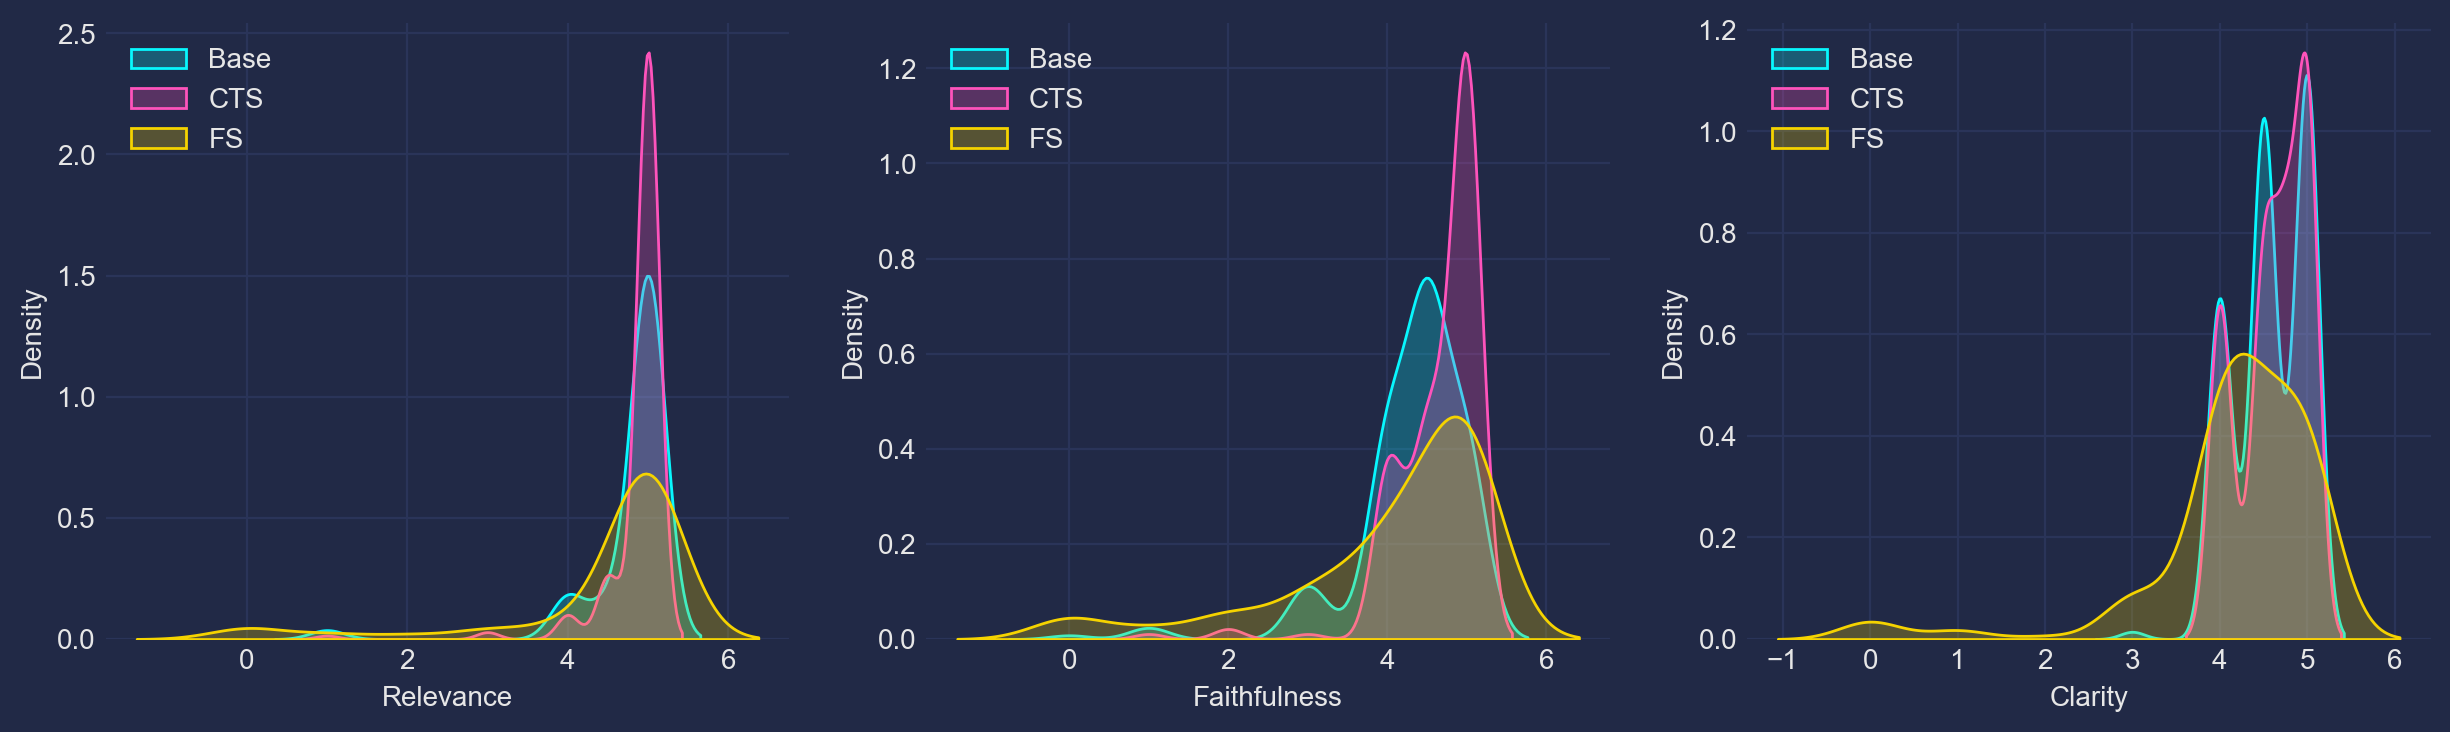

In [126]:
import seaborn as sns
import mplcyberpunk
import matplotlib.pyplot as plt

plt.style.use("cyberpunk")

plt.subplots(1, 3, figsize=(15, 4), dpi=200)

for tp in ["Base", "CTS", "FS"]:
    plt.subplot(1, 3, 1)
    sns.kdeplot(data=df_eval_f, x=f"{tp}_Relevance", fill=True, label=tp)
    plt.xlabel("Relevance")
    plt.legend()

    plt.subplot(1, 3, 2)
    sns.kdeplot(data=df_eval_f, x=f"{tp}_Faithfulness", fill=True, label=tp)
    plt.xlabel("Faithfulness")
    plt.legend()

    plt.subplot(1, 3, 3)
    sns.kdeplot(data=df_eval_f, x=f"{tp}_Clarity", fill=True, label=tp)
    plt.xlabel("Clarity")
    plt.legend();

In [1]:
!jupyter nbconvert --to script evaluations.ipynb

[NbConvertApp] Converting notebook evaluations.ipynb to script
[NbConvertApp] Writing 18479 bytes to evaluations.py
